## Problem 2

Consider the problem of water flowing through a heated square duct (see the figure below).

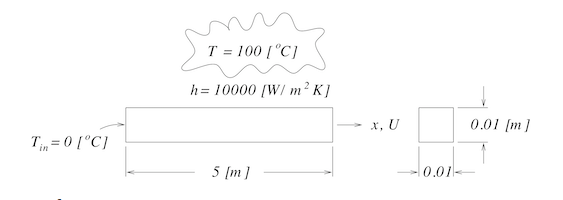

The properties of water are $\rho$ = 1000 [kg/m$^3$], $k$ = 0.590 [W/m$\cdot$K], and $c_p$ = 4189 [J/kg$\cdot$K]. The exact solution for this problem is:

$$
    \frac{T_{\infty}-T(x)}{T_{\infty}-T_{in}}= e^{-\frac{h P_o x}{\dot{m} c_p}}
$$

To solve this problem, start with 5 equal-length control volumes, initialize the temperature and velocity fields as $T$ = 0 [$^\circ$C] and $u$ = 1.5 [m/s], and use a time-step size of $10^{10}$ [s].  At the left boundary, set $\alpha_e = 1$ to ensure that the correct value of $T$ gets carried into the domain.  Then, carry out the following:

1. Solve the problem using UDS, CDS and QUICK and plot $T$ for all schemes along with $T_{exact}$ vs. $x$ with $\alpha_e$ = -1.0 at the right boundary.  Discuss the results.
2. Test the effect of $\alpha_e$ at the right boundary.  That is, set $\alpha_e$ = 1.0 at the right boundary, run the cases of (1) again and discuss the differences that occur.  What physical effect does setting $\alpha_e = \pm1.0$ at the right boundary have?  Which is realistic?
3. Reverse the flow direction and the boundary conditions re-run parts (1) and (2).  Show plots of $T$ vs. $x$.  Make sure you use appropriate values for $\alpha_e$ on the boundaries.  Your solutions should be the same as those from parts (1) and (2), except opposite.

Based on your results for this problem, make a general statement about how $\alpha_e$ should be set on the boundaries and why.

# Class definition

In [62]:
import numpy as np

class Grid:
    """Class defining a one-dimensional Cartesian grid"""

    def __init__(self, lx, ly, lz, ncv):
        """Constructor
            lx .... total length of domain in x-direction [m]
            ly .... total length of domain in x-direction [m]
            lz .... total length of domain in x-direction [m]
            ncv ... number of control volumes in domain
        """
        # Store the number of control volumes
        self._ncv = ncv

        # Calculate the control volume length
        dx = lx/float(ncv)

        # Calculate the face locations
        self._xf = np.array([i*dx for i in range(ncv+1)])

        # Calculate the cell centroid locations
        self._xP = np.array([self._xf[0]] +
                            [0.5*(self._xf[i]+self._xf[i+1]) for i in range(ncv)] +
                            [self._xf[-1]])

        # Calculate face areas
        self._Af = ly*lz*np.ones(ncv+1)

        # Calculate the outer surface area for each cell
        self._Ao = (2.0*dx*ly + 2.0*dx*lz)*np.ones(ncv)

        # Calculate cell volumes
        self._vol = dx*ly*lz*np.ones(ncv)

    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv

    @property
    def xf(self):
        """Face location array"""
        return self._xf

    @property
    def xP(self):
        """Cell centroid array"""
        return self._xP

    @property
    def dx_WP(self):
        return self.xP[1:-1]-self.xP[0:-2]

    @property
    def dx_PE(self):
        return self.xP[2:]-self.xP[1:-1]

    @property
    def Af(self):
        """Face area array"""
        return self._Af

    @property
    def Aw(self):
        """West face area array"""
        return self._Af[0:-1]

    @property
    def Ae(self):
        """East face area array"""
        return self._Af[1:]

    @property
    def Ao(self):
        """Outer face area array"""
        return self._Ao

    @property
    def vol(self):
        """Cell volume array"""
        return self._vol


In [63]:
import numpy as np

class ScalarCoeffs:
    """Class defining the set of coefficients for a finite-volume discretization
       of a scalar partial differential equation.
    """

    def __init__(self, ncv):
        """Constructor
            ncv ... number of control volumes in domain
        """
        self._ncv = ncv
        self._aP = np.zeros(ncv)
        self._aW = np.zeros(ncv)
        self._aE = np.zeros(ncv)
        self._rP = np.zeros(ncv)

    def zero(self):
        """Function to zero the coefficient arrays"""
        self._aP.fill(0.0)
        self._aW.fill(0.0)
        self._aE.fill(0.0)
        self._rP.fill(0.0)

    def accumulate_aP(self, aP):
        """Function to accumulate values onto aP"""
        self._aP += aP

    def accumulate_aW(self, aW):
        """Function to accumulate values onto aW"""
        self._aW += aW

    def accumulate_aE(self, aE):
        """Function to accumulate values onto aE"""
        self._aE += aE

    def accumulate_rP(self, rP):
        """Function to accumulate values onto rP"""
        self._rP += rP

    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv

    @property
    def aP(self):
        """Cell coefficient"""
        return self._aP

    @property
    def aW(self):
        """West cell coefficient"""
        return self._aW

    @property
    def aE(self):
        """East cell coefficient"""
        return self._aE

    @property
    def rP(self):
        """Cell residual"""
        return self._rP


In [64]:
from enum import Enum

class BoundaryLocation(Enum):
    """Enumeration class defining boundary condition locations"""
    WEST = 1
    EAST = 2

class DirichletBc:
    """Class defining a Dirichlet boundary condition"""

    def __init__(self, phi, grid, value, loc):
        """Constructor
            phi ..... field variable array
            grid .... grid
            value ... boundary value
            loc ..... boundary location
        """
        self._phi = phi
        self._grid = grid
        self._value = value
        self._loc = loc

    def value(self):
        """Return the boundary condition value"""
        return self._value

    def coeff(self):
        """Return the linearization coefficient"""
        return 0

    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = self._value
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = self._value
        else:
            raise ValueError("Unknown boundary location")

class NeumannBc:
    """Class defining a Neumann boundary condition"""

    def __init__(self, phi, grid, gradient, loc):
        """Constructor
            phi ........ field variable array
            grid ....... grid
            gradient ... gradient at cell adjacent to boundary
            loc ........ boundary location
        """
        self._phi = phi
        self._grid = grid
        self._gradient = gradient
        self._loc = loc

    def value(self):
        """Return the boundary condition value"""
        if self._loc is BoundaryLocation.WEST:
            return self._phi[1] - self._gradient*self._grid.dx_WP[0]
        elif self._loc is BoundaryLocation.EAST:
            return self._phi[-2] + self._gradient*self._grid.dx_PE[-1]
        else:
            raise ValueError("Unknown boundary location")

    def coeff(self):
        """Return the linearization coefficient"""
        return 1

    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = self._phi[1] - self._gradient*self._grid.dx_WP[0]
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = self._phi[-2] + self._gradient*self._grid.dx_PE[-1]
        else:
            raise ValueError("Unknown boundary location")


In [80]:
class DiffusionModel:
    """Class defining a diffusion model"""

    def __init__(self, grid, phi, gamma, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._gamma = gamma
        self._west_bc = west_bc
        self._east_bc = east_bc

    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""

        # Calculate the west and east face diffusion flux terms for each face
        flux_w = - self._gamma*self._grid.Aw*(self._phi[1:-1]-self._phi[0:-2])/self._grid.dx_WP
        flux_e = - self._gamma*self._grid.Ae*(self._phi[2:]-self._phi[1:-1])/self._grid.dx_PE

        # Calculate the linearization coefficients
        coeffW = - self._gamma*self._grid.Aw/self._grid.dx_WP
        coeffE = - self._gamma*self._grid.Ae/self._grid.dx_PE
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)

        # Return the modified coefficient array
        return coeffs

class SurfaceConvectionModel:
    """Class defining a surface convection model"""

    def __init__(self, grid, T, ho, To):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._ho = ho
        self._To = To

    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""

        # Calculate the source term
        source = self._ho*self._grid.Ao*(self._T[1:-1] - self._To)

        # Calculate the linearization coefficients
        coeffP = self._ho*self._grid.Ao

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(source)

        return coeffs

class FirstOrderTransientModel:
    """Class defining a first order implicit transient model"""

    def __init__(self, grid, T, Told, rho, cp, dt):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._Told = Told
        self._rho = rho
        self._cp = cp
        self._dt = dt

    def add(self, coeffs):
        """Function to add transient term to coefficient arrays"""

        # Calculate the transient term
        transient = self._rho*self._cp*self._grid.vol*(self._T[1:-1]-self._Told[1:-1])/self._dt

        # Calculate the linearization coefficient
        coeff = self._rho*self._cp*self._grid.vol/self._dt

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeff)
        coeffs.accumulate_rP(transient)

        return coeffs


In [81]:
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix

def get_sparse_matrix(coeffs):
    """Function to return a sparse matrix representation of a set of scalar coefficients"""
    ncv = coeffs.ncv
    data = np.zeros(3*ncv-2)
    rows = np.zeros(3*ncv-2, dtype=int)
    cols = np.zeros(3*ncv-2, dtype=int)
    data[0] = coeffs.aP[0]
    data[1] = coeffs.aE[0]
    rows[0] = 0
    cols[0] = 0
    rows[1] = 0
    cols[1] = 1
    for i in range(ncv-2):
        data[3*i+2] = coeffs.aW[i+1]
        data[3*i+3] = coeffs.aP[i+1]
        data[3*i+4] = coeffs.aE[i+1]
        rows[3*i+2:3*i+5] = i+1
        cols[3*i+2] = i
        cols[3*i+3] = i+1
        cols[3*i+4] = i+2
    data[3*ncv-4] = coeffs.aW[-1]
    data[3*ncv-3] = coeffs.aP[-1]
    rows[3*ncv-4:3*ncv-2] = ncv-1
    cols[3*ncv-4] = ncv-2
    cols[3*ncv-3] = ncv-1
    return csr_matrix((data, (rows, cols)))

def solve(coeffs):
    """Function to solve the linear system and return the correction field"""
    # Get the sparse matrix
    A = get_sparse_matrix(coeffs)
    # Solve the linear system
    return spsolve(A, -coeffs.rP)


In [82]:
import numpy as np

class UpwindAdvectionModel:
    """Class defining an upwind advection model"""

    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)

    def add(self, coeffs):
        """Function to add advection terms to coefficient arrays"""

        # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1
        self._alphae[ncv] = -1
        
        # Calculate the east integration point values (including both boundaries)
        self._phie = (1 + self._alphae)/2*self._phi[0:-1] + (1 - self._alphae)/2*self._phi[1:]
        
        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = self._cp*mdote[:-1]*self._phie[:-1]
        flux_e = self._cp*mdote[1:]*self._phie[1:]
        
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

In [83]:
import numpy as np

class CentralDifferenceModel:
    """Class defining an central-difference advection model"""
    
    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)

    def add(self, coeffs):
        """Function to add advection terms to coefficient arrays"""
        
         # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1
        self._alphae[ncv] = -1 
                
        # Calculate the east integration point values (including both boundaries)
        self._phie = 0.5*self._phi[0:-1] + 0.5*self._phi[1:] # CDS
        
        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = self._cp*mdote[:-1]*self._phie[:-1] # CDS
        flux_e = self._cp*mdote[1:]*self._phie[1:]   # CDS
        
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients using UDS
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell using CDS (HOS)
        flux = flux_e - flux_w 

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

In [84]:
import numpy as np

class QUICKAdvectionModel:
    """Class defining an QUICK advection model"""
    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)

    def add(self, coeffs):
        """Function to add advection terms to coefficient arrays"""
        
         # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1
        self._alphae[ncv] = -1 
        
        # Calculate the east integration point values (including both boundaries)            
        for i in range(self._grid.ncv+1):
            if i == 0:
                self._phie[i] = self._phi[i]
            else:
                if self._Uhe[i] >= 0:
                    x_xP = (self._grid.xf[i] - self._grid.xP[i])
                    x_xE = (self._grid.xf[i] - self._grid.xP[i+1])
                    xW_xP = (self._grid.xP[i-1] - self._grid.xP[i])
                    xW_xE = (self._grid.xP[i-1] - self._grid.xP[i+1])
                    t1 = (((x_xP)*(x_xE))/((xW_xP)*(xW_xE)))* self._phi[i-1]
                    x_xW = (self._grid.xf[i] - self._grid.xP[i-1])
                    xP_xW = (self._grid.xP[i] - self._grid.xP[i-1])
                    xP_xE = (self._grid.xP[i] - self._grid.xP[i+1])
                    t2 = (((x_xW)*(x_xE))/((xP_xW)*(xP_xE)))* self._phi[i]
                    xE_xW = (self._grid.xP[i+1] - self._grid.xP[i-1])
                    xE_xP = (self._grid.xP[i+1] - self._grid.xP[i])
                    t3 = (((x_xW)*(x_xP))/((xE_xW)*(xE_xP)))* self._phi[i+1]
                    self._phie[i] = t1 + t2 + t3
                else:
                    x_xEE = (self._grid.xf[i] - self._grid.xP[i+2])
                    xP_xEE = (self._grid.xP[i] - self._grid.xP[i+2])
                    t1 = (((x_xE)*(x_xEE))/((xP_xE)*(xP_xEE)))* self._phi[i]
                    xE_xEE = (self._grid.xP[i+1] - self._grid.xP[i+2])
                    xEE_xP = (self._grid.xP[i+2] - self._grid.xP[i])
                    t2 = (((x_xP)*(x_xEE))/((xE_xP)*(xE_xEE)))* self._phi[i+1]
                    xEE_xE = (self._grid.xP[i+2] - self._grid.xP[i+1])
                    t3 = (((x_xP)*(x_xE))/((xEE_xP)*(xEE_xE)))* self._phi[i+2]
                    self._phie[i] = t1 + t2 + t3

        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = self._cp*mdote[:-1]*self._phie[:-1] #phie[:-1] = Tw
        flux_e = self._cp*mdote[1:]*self._phie[1:]   #phie[1:]  = Te
        
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

## $\alpha_e$ = -1.0 at right boundary
### Solving with Upwind Differencing Scheme (UDS)


In [105]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 5.0
ly = 0.01
lz = 0.01
ncv = 5
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 1
dt = 1e10
time = 0

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1000
cp = 4189
k = 0.590

# Define the surface convection parameters
ho = 10000
To = 373

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 273
U0 = 1.5

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)
Uhe = U0*np.ones(grid.ncv+1)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 273, BoundaryLocation.WEST)
east_bc = NeumannBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Define the advection model
advection = UpwindAdvectionModel(grid, T, Uhe, rho, cp, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = surfaceConvection.add(coeffs)
        coeffs = advection.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
            
xp_uds = grid.xP
T_uds = T
print(T_uds)

# Analytical solution
Po = 4*ly
Af = ly*lz
mdote = rho * U0 * Af
Tinf = 373
Tin =  273
T_exact_5 = Tinf - ((Tinf-Tin)*np.exp((-ho*Po*grid.xP)/(mdote*cp)))


Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 40000.0; Avg. Resid. = 40000.0
Iteration = 1; Max. Resid. = 4.176776193577872e-11; Avg. Resid. = 2.567601342154177e-11
[273.         311.8972595  335.6645524  350.18701917 359.06064403
 364.48267161 364.48267161]


### Solving with Central Differencing Scheme (CDS)

In [103]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 5.0
ly = 0.01
lz = 0.01
ncv = 5
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 1
dt = 1e10
time = 0

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1000
cp = 4189
k = 0.590

# Define the surface convection parameters
ho = 10000
To = 373

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 273
U0 = 1.5

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)
Uhe = U0*np.ones(grid.ncv+1)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 273, BoundaryLocation.WEST)
east_bc = NeumannBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Define the advection model
advection = CentralDifferenceModel(grid, T, Uhe, rho, cp, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = surfaceConvection.add(coeffs)
        coeffs = advection.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
            
xp_cds = grid.xP
T_cds = T
print(T_cds)

Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 40000.0; Avg. Resid. = 40000.0
Iteration = 1; Max. Resid. = 4753.45725877188; Avg. Resid. = 2444.109300923198
Iteration = 2; Max. Resid. = 1129.767671859317; Avg. Resid. = 412.9970810736613
Iteration = 3; Max. Resid. = 335.6438303051532; Avg. Resid. = 147.47711184129307
Iteration = 4; Max. Resid. = 111.68276403868497; Avg. Resid. = 57.27777071017381
Iteration = 5; Max. Resid. = 56.235535755056596; Avg. Resid. = 35.22370255426267
Iteration = 6; Max. Resid. = 35.12019095461682; Avg. Resid. = 23.333498723384047
Iteration = 7; Max. Resid. = 26.254373048928834; Avg. Resid. = 15.779030080625798
Iteration = 8; Max. Resid. = 18.59134526757628; Avg. Resid. = 10.55561074453007
Iteration = 9; Max. Resid. = 13.256932735506723; Avg. Resid. = 6.914016673095863
[273.         318.18344982 342.76114084 356.7080807  363.49175858
 368.81726343 368.81726343]


### Solving with QUICK Advection Scheme 

In [104]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 5.0
ly = 0.01
lz = 0.01
ncv = 5
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 1
dt = 1e10
time = 0

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1000
cp = 4189
k = 0.590

# Define the surface convection parameters
ho = 10000
To = 373

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 273
U0 = 1.5

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)
Uhe = U0*np.ones(grid.ncv+1)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 273, BoundaryLocation.WEST)
east_bc = NeumannBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()
print(T)

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Define the advection model
advection = QUICKAdvectionModel(grid, T, Uhe, rho, cp, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = surfaceConvection.add(coeffs)
        coeffs = advection.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
            
xp_quick = grid.xP
T_quick = T
print(T_quick)

[273. 273. 273. 273. 273. 273. 273.]
Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 40000.0; Avg. Resid. = 40000.0
Iteration = 1; Max. Resid. = 13125.09050030671; Avg. Resid. = 5250.036200122691
Iteration = 2; Max. Resid. = 1513.5391187287648; Avg. Resid. = 605.4156474915019
Iteration = 3; Max. Resid. = 594.4954791822471; Avg. Resid. = 237.79819167289983
Iteration = 4; Max. Resid. = 106.48614838813067; Avg. Resid. = 52.866851405055044
Iteration = 5; Max. Resid. = 24.59579347731343; Avg. Resid. = 9.838317390928966
Iteration = 6; Max. Resid. = 8.04448167812734; Avg. Resid. = 4.579300213395927
Iteration = 7; Max. Resid. = 3.162845284108209; Avg. Resid. = 1.6959148578516747
Iteration = 8; Max. Resid. = 0.886123045130923; Avg. Resid. = 0.5395651734583613
Iteration = 9; Max. Resid. = 0.4039343382269968; Avg. Resid. = 0.1615737352874343
[273.         299.55427184 333.60101306 352.21135019 361.62912315
 368.29994025 368.29994025]


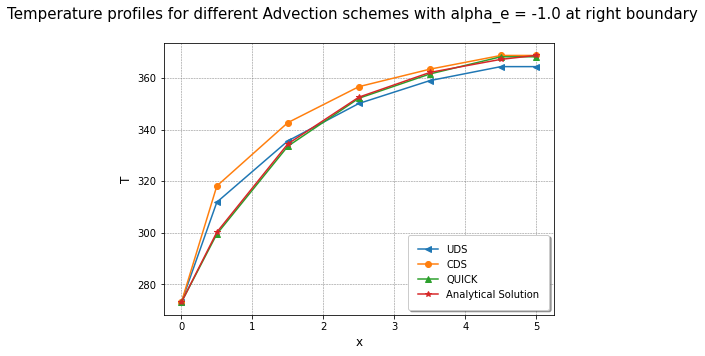

In [116]:
 """Plot for testing Accuracy of Numerical solution with Analytical solution """
%matplotlib inline

import matplotlib.pyplot as plt

plt.figure(figsize =(7,5))

plt.plot(xp_uds, T_uds , marker = "<", label = "UDS")
plt.plot(xp_cds, T_cds, marker = "o", label = "CDS")
plt.plot(xp_quick, T_quick , marker = "^", label = "QUICK")
plt.plot(xp_uds, T_exact_5 , marker = "*", label = "Analytical Solution")
plt.xlabel('x', fontsize = 12)
plt.ylabel('T', fontsize =12)
plt.suptitle('Temperature profiles for different Advection schemes with alpha_e = -1.0 at right boundary', fontsize=15)
plt.grid(True)
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.show()

## Discussion


## $\alpha_e$ = 1.0 at right boundary

In [117]:
import numpy as np

class UpwindAdvectionModel:
    """Class defining an upwind advection model"""

    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)

    def add(self, coeffs):
        """Function to add advection terms to coefficient arrays"""

        # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1
        
        # Calculate the east integration point values (including both boundaries)
        self._phie = (1 + self._alphae)/2*self._phi[0:-1] + (1 - self._alphae)/2*self._phi[1:]
        
        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = self._cp*mdote[:-1]*self._phie[:-1]
        flux_e = self._cp*mdote[1:]*self._phie[1:]
        
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

In [118]:
import numpy as np

class CentralDifferenceModel:
    """Class defining an central-difference advection model"""
    
    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)

    def add(self, coeffs):
        """Function to add advection terms to coefficient arrays"""
        
         # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1
    
        # Calculate the east integration point values (including both boundaries)
        self._phie = 0.5*self._phi[0:-1] + 0.5*self._phi[1:] # CDS
        
        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = self._cp*mdote[:-1]*self._phie[:-1] # CDS
        flux_e = self._cp*mdote[1:]*self._phie[1:]   # CDS
        
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients using UDS
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell using CDS (HOS)
        flux = flux_e - flux_w 

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

In [119]:
import numpy as np

class QUICKAdvectionModel:
    """Class defining an QUICK advection model"""
    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)

    def add(self, coeffs):
        """Function to add advection terms to coefficient arrays"""
        
         # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1
        
        # Calculate the east integration point values (including both boundaries)            
        for i in range(self._grid.ncv+1):
            if i == 0:
                self._phie[i] = self._phi[i]
            else:
                if self._Uhe[i] >= 0:
                    x_xP = (self._grid.xf[i] - self._grid.xP[i])
                    x_xE = (self._grid.xf[i] - self._grid.xP[i+1])
                    xW_xP = (self._grid.xP[i-1] - self._grid.xP[i])
                    xW_xE = (self._grid.xP[i-1] - self._grid.xP[i+1])
                    t1 = (((x_xP)*(x_xE))/((xW_xP)*(xW_xE)))* self._phi[i-1]
                    x_xW = (self._grid.xf[i] - self._grid.xP[i-1])
                    xP_xW = (self._grid.xP[i] - self._grid.xP[i-1])
                    xP_xE = (self._grid.xP[i] - self._grid.xP[i+1])
                    t2 = (((x_xW)*(x_xE))/((xP_xW)*(xP_xE)))* self._phi[i]
                    xE_xW = (self._grid.xP[i+1] - self._grid.xP[i-1])
                    xE_xP = (self._grid.xP[i+1] - self._grid.xP[i])
                    t3 = (((x_xW)*(x_xP))/((xE_xW)*(xE_xP)))* self._phi[i+1]
                    self._phie[i] = t1 + t2 + t3
                else:
                    x_xEE = (self._grid.xf[i] - self._grid.xP[i+2])
                    xP_xEE = (self._grid.xP[i] - self._grid.xP[i+2])
                    t1 = (((x_xE)*(x_xEE))/((xP_xE)*(xP_xEE)))* self._phi[i]
                    xE_xEE = (self._grid.xP[i+1] - self._grid.xP[i+2])
                    xEE_xP = (self._grid.xP[i+2] - self._grid.xP[i])
                    t2 = (((x_xP)*(x_xEE))/((xE_xP)*(xE_xEE)))* self._phi[i+1]
                    xEE_xE = (self._grid.xP[i+2] - self._grid.xP[i+1])
                    t3 = (((x_xP)*(x_xE))/((xEE_xP)*(xEE_xE)))* self._phi[i+2]
                    self._phie[i] = t1 + t2 + t3

        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = self._cp*mdote[:-1]*self._phie[:-1] #phie[:-1] = Tw
        flux_e = self._cp*mdote[1:]*self._phie[1:]   #phie[1:]  = Te
        
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs


### Solving with Upwind Differencing Scheme (UDS)


In [120]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 5.0
ly = 0.01
lz = 0.01
ncv = 5
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 1
dt = 1e10
time = 0

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1000
cp = 4189
k = 0.590

# Define the surface convection parameters
ho = 10000
To = 373

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 273
U0 = 1.5

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)
Uhe = U0*np.ones(grid.ncv+1)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 273, BoundaryLocation.WEST)
east_bc = NeumannBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Define the advection model
advection = UpwindAdvectionModel(grid, T, Uhe, rho, cp, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = surfaceConvection.add(coeffs)
        coeffs = advection.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
            
xp_uds = grid.xP
T_uds = T
print(T_uds)


Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 40000.0; Avg. Resid. = 40000.0
Iteration = 1; Max. Resid. = 4.176776193577872e-11; Avg. Resid. = 2.567601342154177e-11
[273.         311.8972595  335.6645524  350.18701917 359.06064403
 364.48267161 364.48267161]


### Solving with Central Differencing Scheme (CDS)

In [121]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 5.0
ly = 0.01
lz = 0.01
ncv = 5
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 1
dt = 1e10
time = 0

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1000
cp = 4189
k = 0.590

# Define the surface convection parameters
ho = 10000
To = 373

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 273
U0 = 1.5

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)
Uhe = U0*np.ones(grid.ncv+1)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 273, BoundaryLocation.WEST)
east_bc = NeumannBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Define the advection model
advection = CentralDifferenceModel(grid, T, Uhe, rho, cp, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = surfaceConvection.add(coeffs)
        coeffs = advection.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
            
xp_cds = grid.xP
T_cds = T
print(T_cds)

Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 40000.0; Avg. Resid. = 40000.0
Iteration = 1; Max. Resid. = 4753.45725877188; Avg. Resid. = 2444.109300923198
Iteration = 2; Max. Resid. = 1129.767671859317; Avg. Resid. = 412.9970810736613
Iteration = 3; Max. Resid. = 335.6438303051532; Avg. Resid. = 147.47711184129307
Iteration = 4; Max. Resid. = 111.68276403868497; Avg. Resid. = 57.27777071017381
Iteration = 5; Max. Resid. = 56.235535755056596; Avg. Resid. = 35.22370255426267
Iteration = 6; Max. Resid. = 35.12019095461682; Avg. Resid. = 23.333498723384047
Iteration = 7; Max. Resid. = 26.254373048928834; Avg. Resid. = 15.779030080625798
Iteration = 8; Max. Resid. = 18.59134526757628; Avg. Resid. = 10.55561074453007
Iteration = 9; Max. Resid. = 13.256932735506723; Avg. Resid. = 6.914016673095863
[273.         318.18344982 342.76114084 356.7080807  363.49175858
 368.81726343 368.81726343]


### Solving with QUICK Advection Scheme 

In [122]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 5.0
ly = 0.01
lz = 0.01
ncv = 5
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 1
dt = 1e10
time = 0

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1000
cp = 4189
k = 0.590

# Define the surface convection parameters
ho = 10000
To = 373

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 273
U0 = 1.5

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)
Uhe = U0*np.ones(grid.ncv+1)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 273, BoundaryLocation.WEST)
east_bc = NeumannBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()
print(T)

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Define the advection model
advection = QUICKAdvectionModel(grid, T, Uhe, rho, cp, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = surfaceConvection.add(coeffs)
        coeffs = advection.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
            
xp_quick = grid.xP
T_quick = T
print(T_quick)

[273. 273. 273. 273. 273. 273. 273.]
Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 40000.0; Avg. Resid. = 40000.0
Iteration = 1; Max. Resid. = 13125.09050030671; Avg. Resid. = 5250.036200122691
Iteration = 2; Max. Resid. = 1513.5391187287648; Avg. Resid. = 605.4156474915019
Iteration = 3; Max. Resid. = 594.4954791822471; Avg. Resid. = 237.79819167289983
Iteration = 4; Max. Resid. = 106.48614838813067; Avg. Resid. = 52.866851405055044
Iteration = 5; Max. Resid. = 24.59579347731343; Avg. Resid. = 9.838317390928966
Iteration = 6; Max. Resid. = 8.04448167812734; Avg. Resid. = 4.579300213395927
Iteration = 7; Max. Resid. = 3.162845284108209; Avg. Resid. = 1.6959148578516747
Iteration = 8; Max. Resid. = 0.886123045130923; Avg. Resid. = 0.5395651734583613
Iteration = 9; Max. Resid. = 0.4039343382269968; Avg. Resid. = 0.1615737352874343
[273.         299.55427184 333.60101306 352.21135019 361.62912315
 368.29994025 368.29994025]


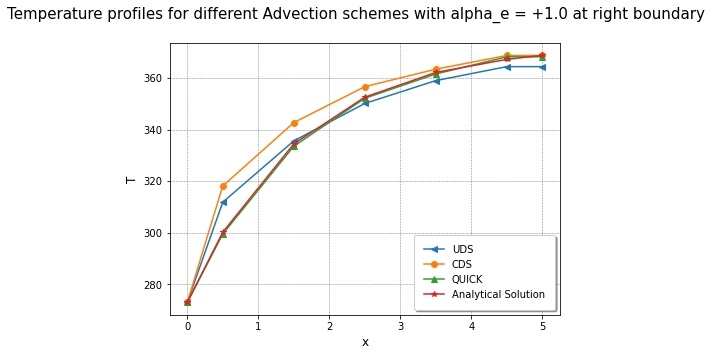

In [124]:
 """Plot for testing Accuracy of Numerical solution with Analytical solution """
%matplotlib inline

import matplotlib.pyplot as plt

plt.figure(figsize =(7,5))

plt.plot(xp_uds, T_uds , marker = "<", label = "UDS")
plt.plot(xp_cds, T_cds, marker = "o", label = "CDS")
plt.plot(xp_quick, T_quick , marker = "^", label = "QUICK")
plt.plot(xp_uds, T_exact_5 , marker = "*", label = "Analytical Solution")
plt.xlabel('x', fontsize = 12)
plt.ylabel('T', fontsize =12)
plt.suptitle('Temperature profiles for different Advection schemes with alpha_e = +1.0 at right boundary ', fontsize=15)
plt.grid(True)
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.show()